In [1]:
import scanpy as sc
adata_all = sc.read_h5ad("GSE253173_single_cell_DREAM.h5ad")
print(adata_all)

AnnData object with n_obs × n_vars = 390373 × 21906
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.celltype.l2', 'LibraryName', 'PFS_6M', 'Timepoint'
    var: 'gene'
    obsm: 'X_ref.umap'


In [2]:
adata_all.obs

nCount_RNA  nFeature_RNA  percent.mt  \
AAACCTGCAGATGGCA-1_1        6783.0          2551    3.479286   
AAACCTGGTAGCTTGT-1_1        3208.0          1605    3.335411   
AAACCTGGTTCACCTC-1_1        3085.0          1302    3.565640   
AAACGGGAGGTTACCT-1_1        1150.0           734   12.347826   
AAACGGGAGTCACGCC-1_1        4431.0          1807    1.850598   
...                            ...           ...         ...   
TTTGTCACAAGTTCTG-1_100      4763.0          1903    5.269788   
TTTGTCACACTTAACG-1_100      6676.0          2443    5.317555   
TTTGTCACATAACCTG-1_100      4472.0          1958    5.210197   
TTTGTCACATAGAAAC-1_100      3542.0          1516    7.227555   
TTTGTCATCGTCTGAA-1_100      4214.0          1890    4.200285   

                       predicted.celltype.l2 LibraryName  PFS_6M  Timepoint  
AAACCTGCAGATGGCA-1_1               CD14 Mono        KH_1       0          0  
AAACCTGGTAGCTTGT-1_1               CD14 Mono        KH_1       0          0  
AAACCTGGTTCACCTC-1_1               CD14 Mono        KH_1       0          0  
AAACGGGAGGTTACCT-1_1                 CD4 TCM        KH_1       0          0  
AAACGGGAGTCACGCC-1_1               CD14 Mono        KH_1       0          0  
...                                      ...         ...     ...        ...  
TTTGTCACAAGTTCTG-1_100               B naive        YY79       1          2  
TTTGTCACACTTAACG-1_100             CD14 Mono        YY79       1          2  
TTTGTCACATAACCTG-1_100                    NK        YY79       1          2  
TTTGTCACATAGAAAC-1_100             CD14 Mono        YY79       1          2  
TTTGTCATCGTCTGAA-1_100                    NK        YY79       1          2  

[390373 rows x 7 columns]

In [3]:
# pull off the barcode prefix (everything before the first “-”)
barcodes = [bc.rsplit('-', 1)[0] for bc in adata_all.obs.index]

# grab the library name column
libs     = adata_all.obs['LibraryName']

# build your new names:  "<barcode>-<LibraryName>"
new_index = [barcodes[i] + '-' + libs[i] for i in range(len(adata_all.obs.index))]
adata_all.obs.index=new_index

In [4]:
t_cell_types = [
'CD4 CTL',
'CD4 Naive',
'CD4 Proliferating',
'CD4 TCM',
'CD4 TEM',
'CD8 Naive',
'CD8 Proliferating',
'CD8 TCM',
'CD8 TEM',
'Treg'
]
adata_all = adata_all[adata_all.obs["predicted.celltype.l2"].isin(t_cell_types)]
adata_all

View of AnnData object with n_obs × n_vars = 175067 × 21906
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.celltype.l2', 'LibraryName', 'PFS_6M', 'Timepoint'
    var: 'gene'
    obsm: 'X_ref.umap'

In [5]:
# 1) split
adatas = []
for lib in adata_all.obs['LibraryName'].unique():
    ad = adata_all[adata_all.obs['LibraryName'] == lib].copy()
    ad.obs['LibraryName'] = lib  # ensure the obs column survives
    adatas.append(ad)

# 2) per‐sample normalize & log
for ad in adatas:
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# 3) put ’em back together
adata_norm = adatas[0].concatenate(
    adatas[1:],
    batch_key='LibraryName',
    index_unique=None       # keep original cell barcodes
)


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [6]:
all_genes = set(adata_all.var['gene'].values)
markers = {
    "CD4": ["FOXP3", "IL2RA", "CD4"], #"TRBC2" [CD3D, CD3E, CXCR4, IL7R, LTB, TRBC2] ["IL7R", "CCR7","FOXP3"]  ["CD4", "IL7R", "TRBC2"] https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2023.1151109/full
    "CD8": ["CD8A", "CD8B"], #"NKG7" ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "NKG7", "PRF1", "GNLY", "CCR5", "CXCR3"]
}
for cell_type, gene_list in markers.items():
    present = [g for g in gene_list if g in all_genes]
    missing = [g for g in gene_list if g not in all_genes]
    print(f"{cell_type} markers:")
    print(" • present:", present)
    print(" • missing:", missing, "\n")

CD4 markers:
 • present: ['FOXP3', 'IL2RA', 'CD4']
 • missing: [] 

CD8 markers:
 • present: ['CD8A', 'CD8B']
 • missing: [] 



In [7]:
%matplotlib inline

hvg_n         = 5000                           # #HVGs to keep
leiden_res    = 1                            # tweak for cluster granularity

# -------------------- feature selection & scaling -------------------------
sc.pp.highly_variable_genes(adata_all, n_top_genes=hvg_n,  flavor="seurat_v3", batch_key="LibraryName")


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


In [8]:
# adata_all.var.set_index("gene", inplace=True)
# adata_all.var.loc["CD4", "highly_variable"] = True
adata_all = adata_norm[:, adata_all.var["highly_variable"]]  # subset to HVGs
print(adata_all)

View of AnnData object with n_obs × n_vars = 175067 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.celltype.l2', 'LibraryName', 'PFS_6M', 'Timepoint'
    var: 'gene'
    obsm: 'X_ref.umap'


In [9]:
all_genes = set(adata_all.var['gene'].values)
for cell_type, gene_list in markers.items():
    present = [g for g in gene_list if g in all_genes]
    missing = [g for g in gene_list if g not in all_genes]
    print(f"{cell_type} markers:")
    print(" • present:", present)
    print(" • missing:", missing, "\n")

CD4 markers:
 • present: ['FOXP3', 'IL2RA', 'CD4']
 • missing: [] 

CD8 markers:
 • present: ['CD8A', 'CD8B']
 • missing: [] 



In [10]:
sc.pp.scale(adata_all, max_value=10)

# ----------------------- dimensionality + clustering ----------------------
sc.tl.pca(adata_all, svd_solver="arpack")
sc.external.pp.harmony_integrate(adata_all, key='LibraryName')
#  build neighborhood graph & UMAP on the *corrected* embedding
sc.pp.neighbors(adata_all, use_rep='X_pca_harmony')
sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")
sc.tl.umap(adata_all)  

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-05-20 14:44:16,840 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-20 14:44:52,465 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-20 14:44:53,242 - harmonypy - INFO - Iteration 1 of 10
2025-05-20 14:46:46,525 - harmonypy - INFO - Iteration 2 of 10
2025-05-20 14:48:41,411 - harmonypy - INFO - Iteration 3 of 10
2025-05-20 14:50:33,067 - harmonypy - INFO - Iteration 4 of 10
2025-05-20 14:51:58,938 - harmonypy - INFO - Iteration 5 of 10
2025-05-20 14:53:51,521 - harmonypy - INFO - Converged after 5 iterations
/app/software/umap-learn/0.5.3-foss-2022b/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

In [11]:
adata_all.var_names = adata_all.var['gene']

sc.tl.score_genes(adata_all, gene_list=markers["CD4"], score_name="CD4_score")
sc.tl.score_genes(adata_all, gene_list=markers["CD8"], score_name="CD8_score")

# coarse per‑cluster means
clust_means = (
    adata_all.obs[["cluster", "CD4_score", "CD8_score"]]
    .groupby("cluster")
    .mean()
)
clust_means

CD4_score  CD8_score
cluster                      
0        -0.405910   0.899767
1         0.085958  -0.482202
2         0.031790  -0.466893
3         0.115239  -0.496384
4         0.083359  -0.443773
5         0.276325  -0.222185
6        -0.351985   1.211907
7         0.014167  -0.595835
8        -0.278257   1.352252
9         1.718102  -0.592708
10       -0.125594   0.414529
11       -0.295212   0.749477
12       -0.449020   0.939178
13       -0.264454  -0.064454
14       -0.105566   0.244007
15       -0.324985  -0.101008
16       -0.458255   1.779131
17       -0.129750  -0.118295
18        0.035130  -0.379858
19       -0.579212   1.051672
20       -0.428291   0.758708

In [12]:
import numpy as np
# label clusters: whichever marker score is higher
clust_means["predicted_type"] = np.where(
    clust_means["CD4_score"] > clust_means["CD8_score"], "CD4", "CD8"
)


# map back to every cell
adata_all.obs["CD_type_by_cluster"] = (
    adata_all.obs["cluster"].map(clust_means["predicted_type"])
)

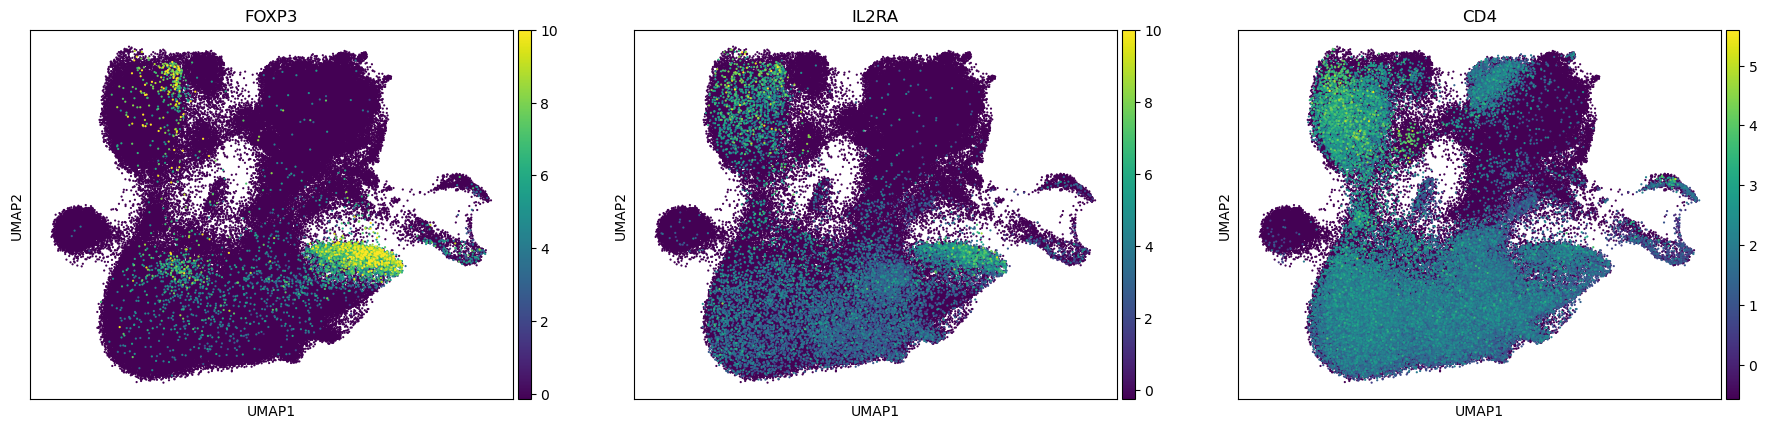

In [13]:
%matplotlib inline

marker_genes_CD4 = markers["CD4"]
marker_genes_CD8 = markers["CD8"]
# now plot cluster / annotation + all marker genes in one go
sc.pl.umap(
    adata_all,
    color=marker_genes_CD4,
    ncols=5,                # how many panels per row
    size=10,                # dot size
    legend_loc="right margin",
    cmap="viridis",         # continuous color map for gene expr.
)

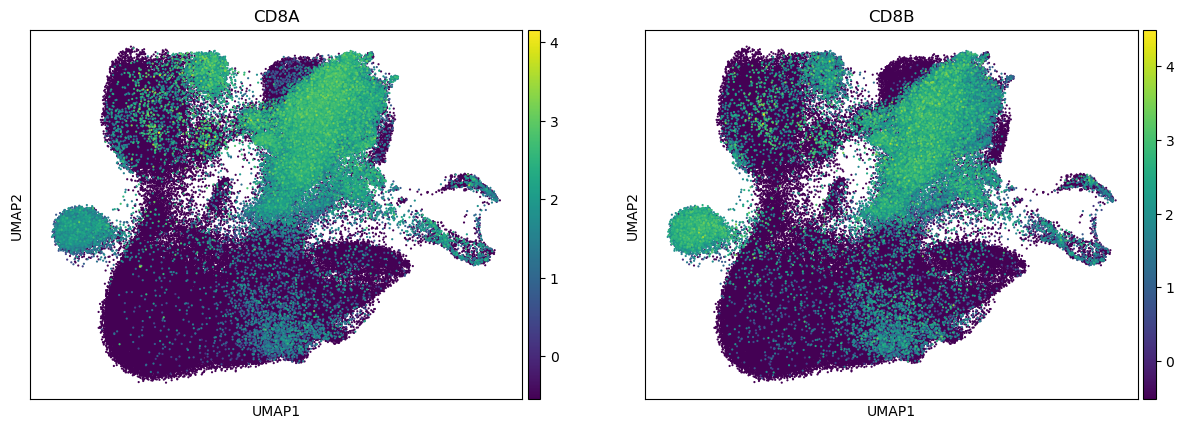

In [14]:
sc.pl.umap(
    adata_all,
    color=marker_genes_CD8,
    ncols=5,                # how many panels per row
    size=10,                # dot size
    legend_loc="right margin",
    cmap="viridis",         # continuous color map for gene expr.
)

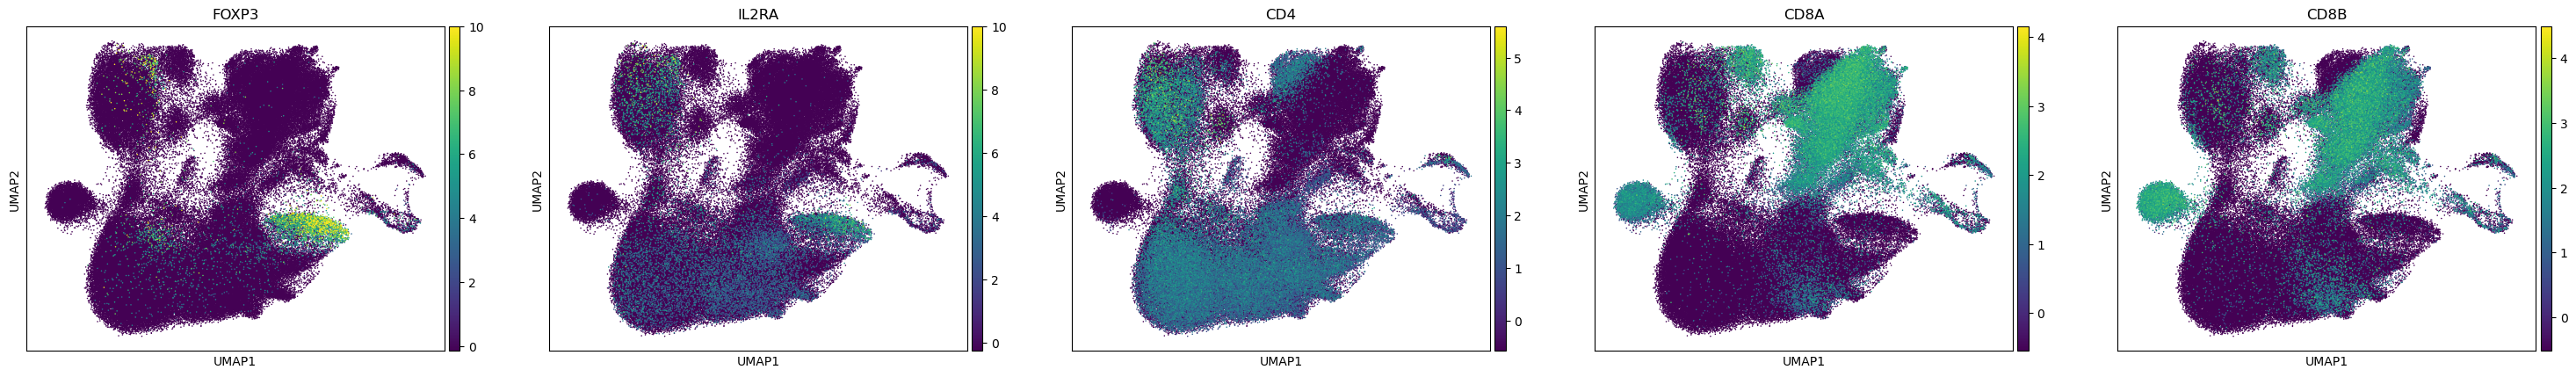

In [15]:
genes4 = marker_genes_CD4
genes8 = marker_genes_CD8

allgenes = genes4 + genes8

sc.pl.umap(
    adata_all,
    color=allgenes,
    ncols=5,
    size=5,                    # same dot size
    cmap="viridis",
    legend_loc="right margin"
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


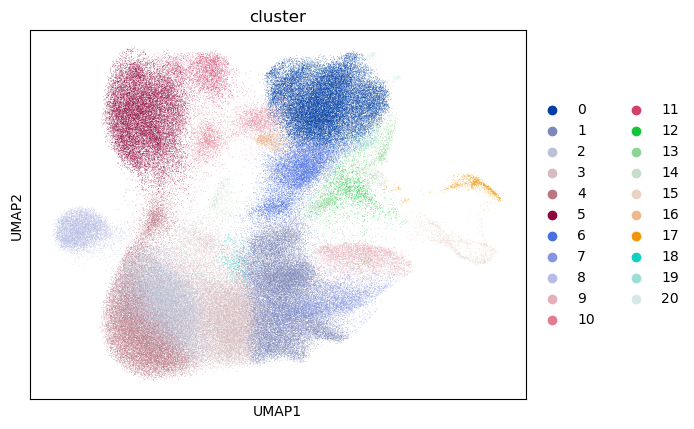

In [16]:
%matplotlib inline
sc.pl.umap(adata_all, color=["cluster"])


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


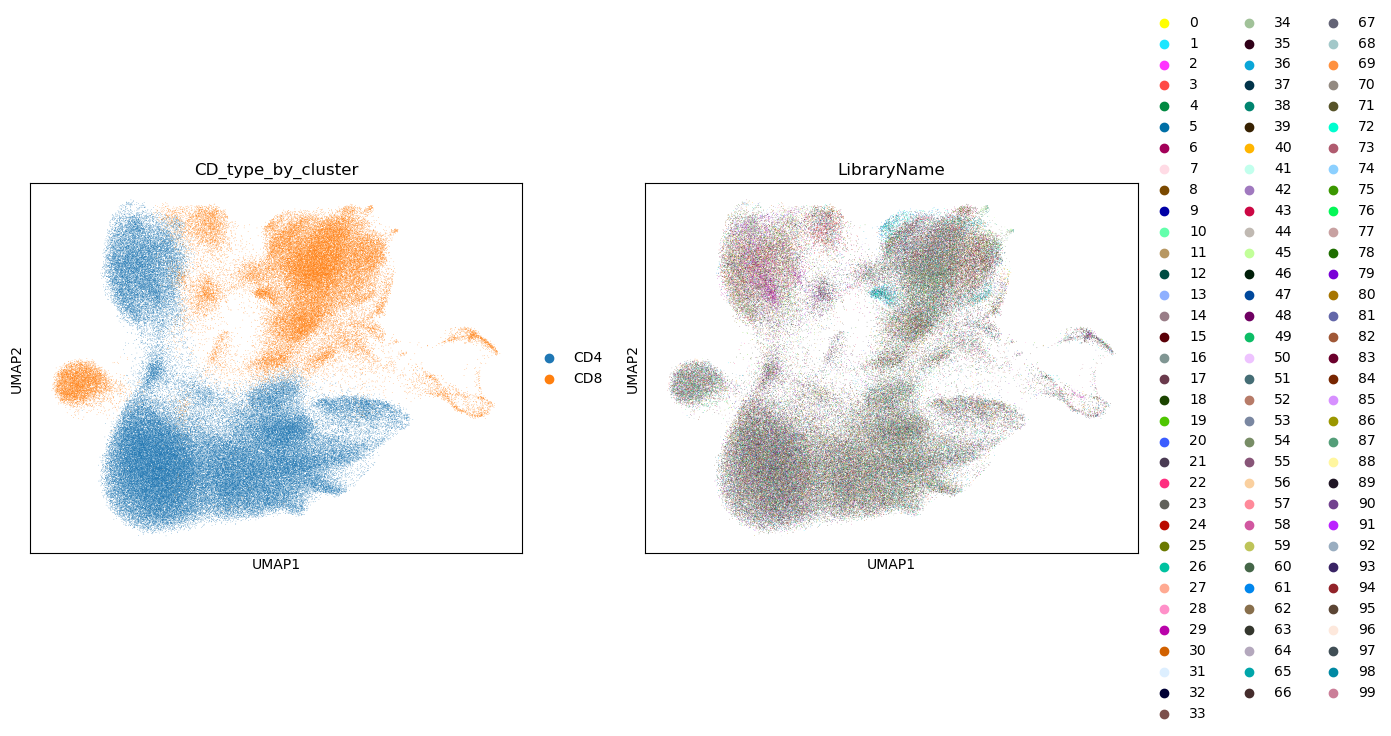

In [17]:
%matplotlib inline
sc.pl.umap(adata_all, color=["CD_type_by_cluster", "LibraryName"])

In [18]:
adata_all.obs

nCount_RNA  nFeature_RNA  percent.mt  \
AAACGGGAGGTTACCT-KH_1      1150.0           734   12.347826   
AAACGGGGTCCGTGAC-KH_1      4552.0          1526    2.789982   
AAAGCAAAGAAGGCCT-KH_1      3543.0          1246    4.318374   
AAAGCAACACGAAACG-KH_1      1289.0           863   10.240497   
AAAGTAGCAATCCGAT-KH_1      1765.0           873    4.475921   
...                           ...           ...         ...   
TTTGGTTCATCACCCT-YY79      4592.0          1965    4.137631   
TTTGGTTCATCCGGGT-YY79      4550.0          1429    4.747253   
TTTGGTTCATGCCTAA-YY79      3585.0          1887    5.216179   
TTTGGTTCATTGGTAC-YY79      6561.0          1845    4.389575   
TTTGGTTGTGTGGCTC-YY79     21609.0          4769    4.336156   

                      predicted.celltype.l2 LibraryName  PFS_6M  Timepoint  \
AAACGGGAGGTTACCT-KH_1               CD4 TCM           0       0          0   
AAACGGGGTCCGTGAC-KH_1               CD4 TCM           0       0          0   
AAAGCAAAGAAGGCCT-KH_1               CD4 TCM           0       0          0   
AAAGCAACACGAAACG-KH_1             CD4 Naive           0       0          0   
AAAGTAGCAATCCGAT-KH_1               CD4 TCM           0       0          0   
...                                     ...         ...     ...        ...   
TTTGGTTCATCACCCT-YY79               CD8 TEM          99       1          2   
TTTGGTTCATCCGGGT-YY79             CD8 Naive          99       1          2   
TTTGGTTCATGCCTAA-YY79               CD8 TEM          99       1          2   
TTTGGTTCATTGGTAC-YY79             CD8 Naive          99       1          2   
TTTGGTTGTGTGGCTC-YY79     CD4 Proliferating          99       1          2   

                      cluster  CD4_score  CD8_score CD_type_by_cluster  
AAACGGGAGGTTACCT-KH_1       5  -0.188362   0.068909                CD4  
AAACGGGGTCCGTGAC-KH_1       2  -0.286686  -0.678050                CD4  
AAAGCAAAGAAGGCCT-KH_1       2  -0.117042  -0.478192                CD4  
AAAGCAACACGAAACG-KH_1       5  -0.072968  -0.178055                CD4  
AAAGTAGCAATCCGAT-KH_1       1   0.650370  -0.341930                CD4  
...                       ...        ...        ...                ...  
TTTGGTTCATCACCCT-YY79       0  -0.463097   0.750996                CD8  
TTTGGTTCATCCGGGT-YY79       8  -0.199469   0.560971                CD8  
TTTGGTTCATGCCTAA-YY79       0  -0.534737  -0.636416                CD8  
TTTGGTTCATTGGTAC-YY79       8  -0.243274   1.239323                CD8  
TTTGGTTGTGTGGCTC-YY79      15  -0.874300   1.567318                CD8  

[175067 rows x 11 columns]

In [19]:
import pandas as pd

# pull out your obs DataFrame
obs = adata_all.obs.copy()

# define how each subtype maps to the coarse CD4/CD8 call
subtype2coarse = {
    'CD4 CTL': 'CD4',
    'CD4 Naive': 'CD4',
    'CD4 Proliferating': 'CD4',
    'CD4 TCM': 'CD4',
    'CD4 TEM': 'CD4',
    'Treg': 'CD4',            # Tregs are CD4+
    'CD8 Naive': 'CD8',
    'CD8 Proliferating': 'CD8',
    'CD8 TCM': 'CD8',
    'CD8 TEM': 'CD8',
}

# create a new column with the mapped coarse type
obs['CD_type_from_predicted_l2'] = obs['predicted.celltype.l2'].map(subtype2coarse)

# now find all cells where that mapped type !=  cluster‐based call
mismatches = obs[
    obs['CD_type_from_predicted_l2'] != obs['CD_type_by_cluster']
]

mismatches

nCount_RNA  nFeature_RNA  percent.mt  \
ACATACGCACAGGTTT-KH_1      6350.0          2274    3.905512   
ACATACGTCGCTGATA-KH_1      1483.0           969    6.540796   
AGAGTGGTCCACGTGG-KH_1       727.0           487   12.654746   
AGGCCACGTGGCGAAT-KH_1      6503.0          2572    3.183146   
AGGGAGTTCGGAATCT-KH_1       634.0           443   11.987382   
...                           ...           ...         ...   
TTGCCGTGTTCACCTC-YY79     36874.0          5820    2.337691   
TTGCGTCTCATGCATG-YY79      1954.0          1040    6.090072   
TTGCGTCTCTCACATT-YY79     15145.0          3878    5.374711   
TTTGCGCAGATGTCGG-YY79       857.0           442    6.301050   
TTTGGTTGTGTGGCTC-YY79     21609.0          4769    4.336156   

                      predicted.celltype.l2 LibraryName  PFS_6M  Timepoint  \
ACATACGCACAGGTTT-KH_1               CD4 TCM           0       0          0   
ACATACGTCGCTGATA-KH_1               CD8 TEM           0       0          0   
AGAGTGGTCCACGTGG-KH_1               CD4 TCM           0       0          0   
AGGCCACGTGGCGAAT-KH_1     CD4 Proliferating           0       0          0   
AGGGAGTTCGGAATCT-KH_1               CD8 TEM           0       0          0   
...                                     ...         ...     ...        ...   
TTGCCGTGTTCACCTC-YY79     CD4 Proliferating          99       1          2   
TTGCGTCTCATGCATG-YY79               CD8 TEM          99       1          2   
TTGCGTCTCTCACATT-YY79               CD4 TCM          99       1          2   
TTTGCGCAGATGTCGG-YY79               CD4 TCM          99       1          2   
TTTGGTTGTGTGGCTC-YY79     CD4 Proliferating          99       1          2   

                      cluster  CD4_score  CD8_score CD_type_by_cluster  \
ACATACGCACAGGTTT-KH_1       8  -0.399374   1.373162                CD8   
ACATACGTCGCTGATA-KH_1       5  -0.082965   0.802320                CD4   
AGAGTGGTCCACGTGG-KH_1      10  -0.163588  -0.068800                CD8   
AGGCCACGTGGCGAAT-KH_1      15   1.851976  -1.081440                CD8   
AGGGAGTTCGGAATCT-KH_1       5  -0.062795  -0.003695                CD4   
...                       ...        ...        ...                ...   
TTGCCGTGTTCACCTC-YY79      15  -0.474339  -1.138116                CD8   
TTGCGTCTCATGCATG-YY79       5  -0.387135   0.399270                CD4   
TTGCGTCTCTCACATT-YY79      15  -0.134282  -1.031337                CD8   
TTTGCGCAGATGTCGG-YY79      10  -0.148812  -0.162364                CD8   
TTTGGTTGTGTGGCTC-YY79      15  -0.874300   1.567318                CD8   

                      CD_type_from_predicted_l2  
ACATACGCACAGGTTT-KH_1                       CD4  
ACATACGTCGCTGATA-KH_1                       CD8  
AGAGTGGTCCACGTGG-KH_1                       CD4  
AGGCCACGTGGCGAAT-KH_1                       CD4  
AGGGAGTTCGGAATCT-KH_1                       CD8  
...                                         ...  
TTGCCGTGTTCACCTC-YY79                       CD4  
TTGCGTCTCATGCATG-YY79                       CD8  
TTGCGTCTCTCACATT-YY79                       CD4  
TTTGCGCAGATGTCGG-YY79                       CD4  
TTTGGTTGTGTGGCTC-YY79                       CD4  

[11816 rows x 12 columns]

In [20]:
obs['mismatch'] = (
    obs['CD_type_from_predicted_l2'] != 
    obs['CD_type_by_cluster']
)

cluster_summary = (
    obs
    .groupby('cluster')['mismatch']
    .agg(
        n_total='count', 
        n_mismatch='sum', 
        prop_mismatch='mean'
    )
    .sort_values('prop_mismatch', ascending=False)
)

cluster_summary

n_total  n_mismatch  prop_mismatch
cluster                                    
15          1307         864       0.661056
17           953         554       0.581322
14          1530         841       0.549673
10          3918        1454       0.371108
13          1878         373       0.198616
0          25796        2911       0.112847
12          2184         220       0.100733
5          17820        1781       0.099944
18           568          39       0.068662
11          2981         191       0.064072
8           6007         316       0.052605
6          10046         472       0.046984
1          25571        1092       0.042705
7           6114         176       0.028786
3          19678         229       0.011637
4          19201         169       0.008802
9           4836          26       0.005376
2          22884         108       0.004719
16          1051           0       0.000000
19           438           0       0.000000
20           306           0       0.000000

Clusters to highlight: ['15', '17', '14', '10']


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


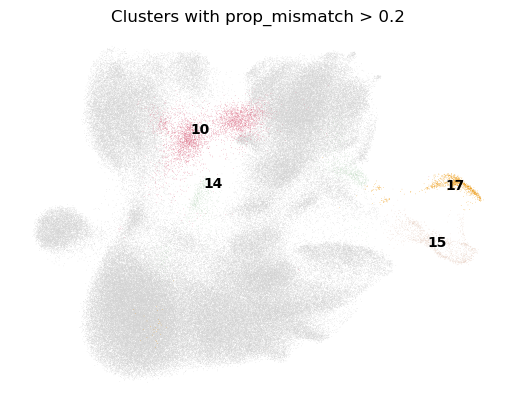

In [21]:
mismatch_clusters = (
    cluster_summary               # the table you printed in cell [17]
      .query("prop_mismatch > 0.2")
      .index                      # these are the cluster labels
      .astype(str)                # Scanpy stores cluster labels as strings
      .tolist()
)

print("Clusters to highlight:", mismatch_clusters)

# --- 2. draw the UMAP, colouring by cluster and highlighting just those ------
sc.pl.umap(
    adata_all,
    color="cluster",              # column that stores the cluster ID
    groups=mismatch_clusters,     # only show these clusters in colour
    legend_loc="on data",         # put the labels on the plot
    frameon=False,
    na_in_legend=False, 
    title="Clusters with prop_mismatch > 0.2"
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


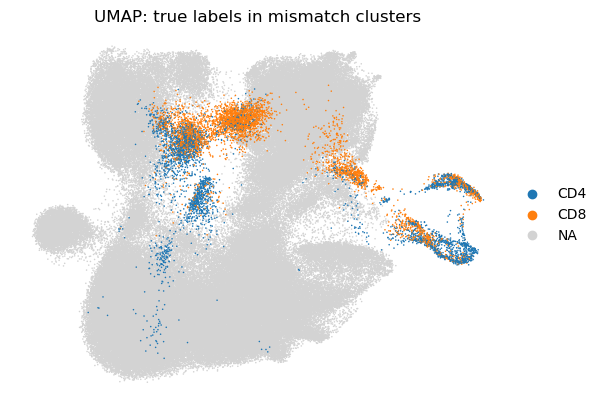

In [22]:
t_cells = {'CD4':[
'CD4 CTL',
'CD4 Naive',
'CD4 Proliferating',
'CD4 TCM',
'CD4 TEM', 'Treg'], 'CD8':[
'CD8 Naive',
'CD8 Proliferating',
'CD8 TCM',
'CD8 TEM']
}
sub2label = {}
for label, subs in t_cells.items():
    for sub in subs:
        sub2label[sub] = label

#  map existing SubCellType column to the new labels
adata_all.obs['cell_type_true_label'] = (
    adata_all.obs['predicted.celltype.l2']
    .map(sub2label)
    .fillna('Unknown')      # in case there are SubCellTypes not in t_cells
)

# boolean mask of cells in those clusters
mask = adata_all.obs['cluster'].astype(str).isin(mismatch_clusters)

# create a one‐column “highlight”:
#   CD4 or CD8 for mismatches, Other otherwise
adata_all.obs['highlight'] = np.where(
    mask,
    adata_all.obs['cell_type_true_label'],
    'Other'
)

# now plot exactly like your first plot:
sc.pl.umap(
    adata_all,
    color='highlight',          # this column is now categorical: CD4, CD8, Other
    groups=['CD4','CD8'],       # only these get the Scanpy default colors
    size=5,                    # same dot size as before
    frameon=False,
    legend_loc='right margin',  # or 'on data' if you prefer labels placed over clusters
    title='UMAP: true labels in mismatch clusters'
)

In [23]:
adata_all.obs.to_csv('cell_types.csv',index = True)

## Now we compare the same process without Harmony.

In [22]:
import scanpy as sc
adata_all = sc.read_h5ad("GSE253173_single_cell_DREAM.h5ad")
print(adata_all)

AnnData object with n_obs × n_vars = 390373 × 21906
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.celltype.l2', 'LibraryName', 'PFS_6M', 'Timepoint'
    var: 'gene'
    obsm: 'X_ref.umap'


In [23]:
t_cell_types = [
'CD4 CTL',
'CD4 Naive',
'CD4 Proliferating',
'CD4 TCM',
'CD4 TEM',
'CD8 Naive',
'CD8 Proliferating',
'CD8 TCM',
'CD8 TEM',
'Treg'
]
adata_all = adata_all[adata_all.obs["predicted.celltype.l2"].isin(t_cell_types)]
adata_all

View of AnnData object with n_obs × n_vars = 175067 × 21906
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.celltype.l2', 'LibraryName', 'PFS_6M', 'Timepoint'
    var: 'gene'
    obsm: 'X_ref.umap'

In [24]:
# 1) split
adatas = []
for lib in adata_all.obs['LibraryName'].unique():
    ad = adata_all[adata_all.obs['LibraryName'] == lib].copy()
    ad.obs['LibraryName'] = lib  # ensure the obs column survives
    adatas.append(ad)

# 2) per‐sample normalize & log
for ad in adatas:
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# 3) put ’em back together
adata_norm = adatas[0].concatenate(
    adatas[1:],
    batch_key='LibraryName',
    index_unique=None       # keep original cell barcodes
)


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [25]:
all_genes = set(adata_all.var['gene'].values)
markers = {
    "CD4": ["FOXP3", "IL2RA", "CD4"], #"TRBC2" [CD3D, CD3E, CXCR4, IL7R, LTB, TRBC2] ["IL7R", "CCR7","FOXP3"]  ["CD4", "IL7R", "TRBC2"] https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2023.1151109/full
    "CD8": ["CD8A", "CD8B"], #"NKG7" ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "NKG7", "PRF1", "GNLY", "CCR5", "CXCR3"]
}
for cell_type, gene_list in markers.items():
    present = [g for g in gene_list if g in all_genes]
    missing = [g for g in gene_list if g not in all_genes]
    print(f"{cell_type} markers:")
    print(" • present:", present)
    print(" • missing:", missing, "\n")

CD4 markers:
 • present: ['FOXP3', 'IL2RA', 'CD4']
 • missing: [] 

CD8 markers:
 • present: ['CD8A', 'CD8B']
 • missing: [] 



In [26]:
%matplotlib inline

hvg_n         = 5000                           # #HVGs to keep
leiden_res    = 1                            # tweak for cluster granularity

# -------------------- feature selection & scaling -------------------------
sc.pp.highly_variable_genes(adata_all, n_top_genes=hvg_n,  flavor="seurat_v3", batch_key="LibraryName")

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


In [27]:
adata_all = adata_norm[:, adata_all.var["highly_variable"]]  # subset to HVGs
print(adata_all)

View of AnnData object with n_obs × n_vars = 175067 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'predicted.celltype.l2', 'LibraryName', 'PFS_6M', 'Timepoint'
    var: 'gene'
    obsm: 'X_ref.umap'


In [28]:
all_genes = set(adata_all.var['gene'].values)
for cell_type, gene_list in markers.items():
    present = [g for g in gene_list if g in all_genes]
    missing = [g for g in gene_list if g not in all_genes]
    print(f"{cell_type} markers:")
    print(" • present:", present)
    print(" • missing:", missing, "\n")

CD4 markers:
 • present: ['FOXP3', 'IL2RA', 'CD4']
 • missing: [] 

CD8 markers:
 • present: ['CD8A', 'CD8B']
 • missing: [] 



In [29]:
sc.pp.scale(adata_all, max_value=10)

# ----------------------- dimensionality + clustering ----------------------
sc.tl.pca(adata_all, svd_solver="arpack")
sc.pp.neighbors(adata_all,n_neighbors=15, n_pcs=40)
sc.tl.leiden(adata_all, resolution=leiden_res, key_added="cluster")
sc.tl.umap(adata_all)       

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
adata_all.var_names = adata_all.var['gene']

sc.tl.score_genes(adata_all, gene_list=markers["CD4"], score_name="CD4_score")
sc.tl.score_genes(adata_all, gene_list=markers["CD8"], score_name="CD8_score")

# coarse per‑cluster means
clust_means = (
    adata_all.obs[["cluster", "CD4_score", "CD8_score"]]
    .groupby("cluster")
    .mean()
)
clust_means

CD4_score  CD8_score
cluster                      
0         0.057498  -0.398509
1         0.101598  -0.476417
2         0.064820  -0.536726
3         0.086454  -0.509711
4         0.305030  -0.284823
5        -0.441050   1.336683
6        -0.344103   1.184609
7        -0.489205   0.736960
8         0.014073  -0.601567
9        -0.278599   1.364872
10        1.734756  -0.589794
11       -0.140342  -0.530455
12        0.008719   0.170976
13       -0.250408   0.663584
14       -0.413794   1.420426
15       -0.402060   0.426132
16       -0.016332  -0.471257
17        0.242483  -0.229838
18       -0.081571   0.178633
19       -0.455129   1.733902
20       -0.386152   0.740882
21       -0.203458   0.134867
22       -0.133578  -0.177450
23        0.258983  -0.604776
24        0.020471  -0.499698
25       -0.102583  -0.249704

In [31]:
import numpy as np
# label clusters: whichever marker score is higher
clust_means["predicted_type"] = np.where(
    clust_means["CD4_score"] > clust_means["CD8_score"], "CD4", "CD8"
)


# map back to every cell
adata_all.obs["CD_type_by_cluster"] = (
    adata_all.obs["cluster"].map(clust_means["predicted_type"])
)

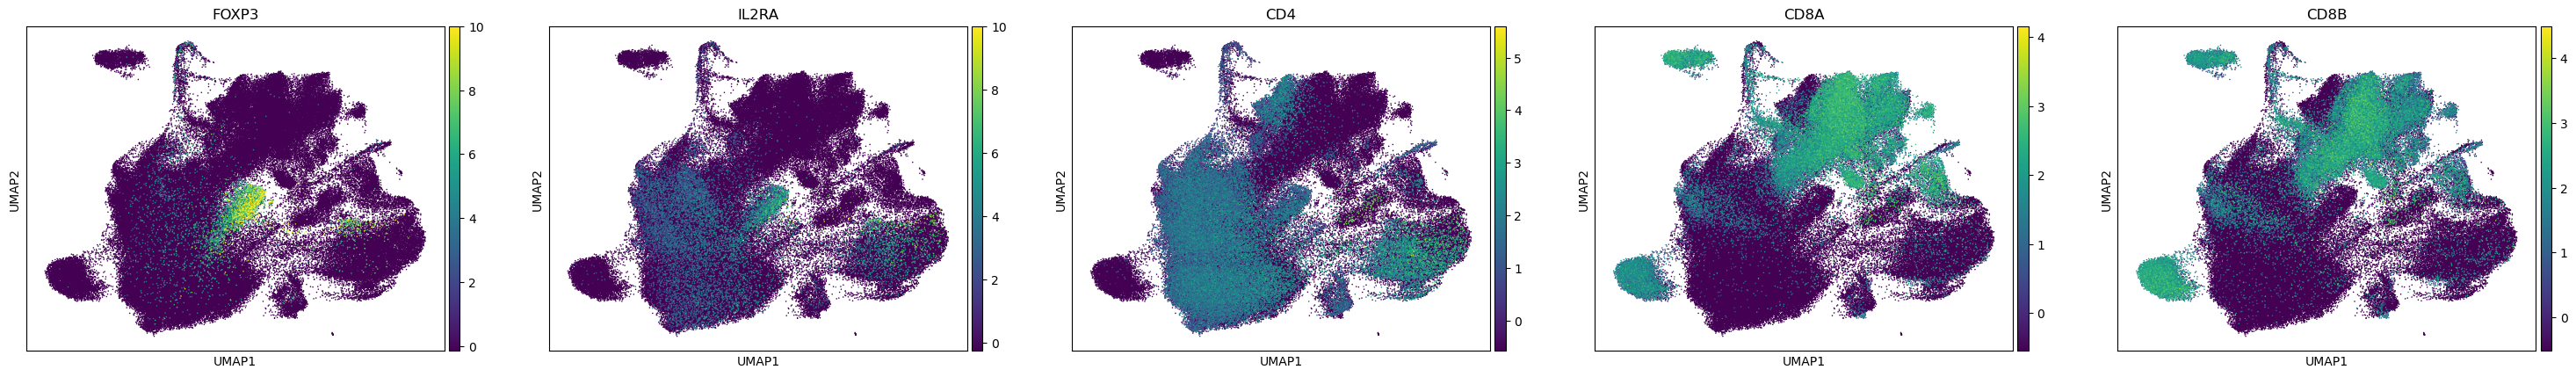

In [32]:
%matplotlib inline

marker_genes_CD4 = markers["CD4"]
marker_genes_CD8 = markers["CD8"]
genes4 = marker_genes_CD4
genes8 = marker_genes_CD8

allgenes = genes4 + genes8

sc.pl.umap(
    adata_all,
    color=allgenes,
    ncols=5,
    size=5,                    # same dot size
    cmap="viridis",
    legend_loc="right margin"
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


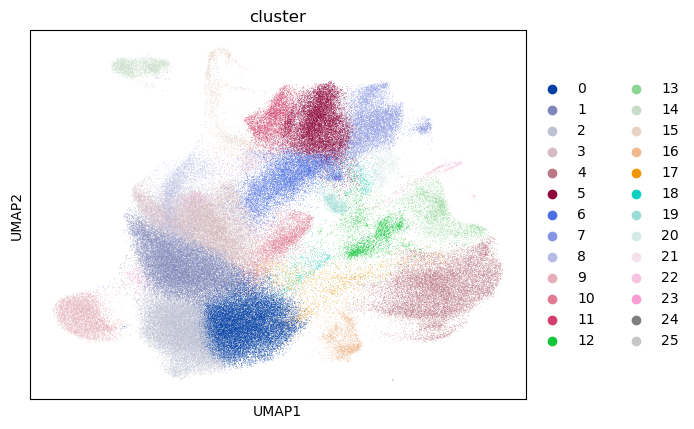

In [33]:
%matplotlib inline
sc.pl.umap(adata_all, color=["cluster"])

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


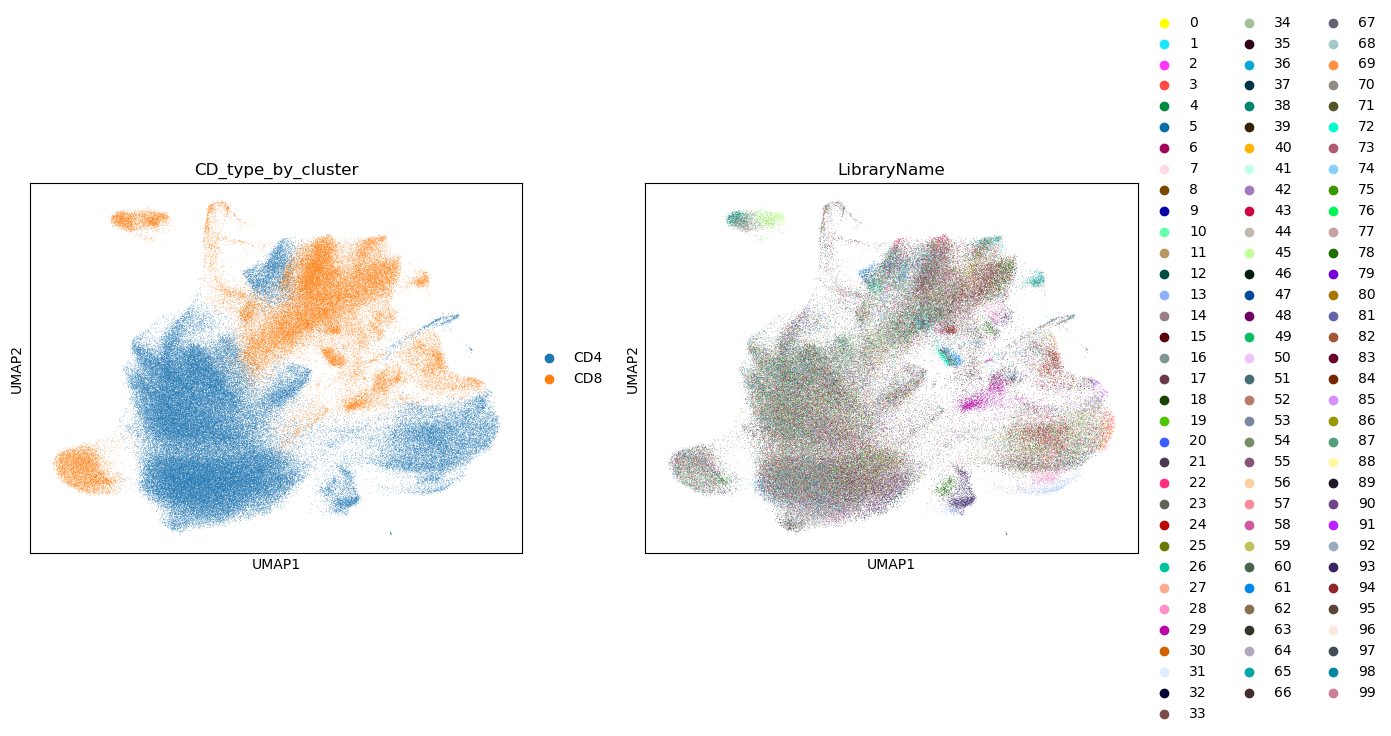

In [34]:
%matplotlib inline
sc.pl.umap(adata_all, color=["CD_type_by_cluster", "LibraryName"])

In [35]:
import pandas as pd

# pull out your obs DataFrame
obs = adata_all.obs.copy()

# define how each subtype maps to the coarse CD4/CD8 call
subtype2coarse = {
    'CD4 CTL': 'CD4',
    'CD4 Naive': 'CD4',
    'CD4 Proliferating': 'CD4',
    'CD4 TCM': 'CD4',
    'CD4 TEM': 'CD4',
    'Treg': 'CD4',            # Tregs are CD4+
    'CD8 Naive': 'CD8',
    'CD8 Proliferating': 'CD8',
    'CD8 TCM': 'CD8',
    'CD8 TEM': 'CD8',
}

# create a new column with the mapped coarse type
obs['CD_type_from_predicted_l2'] = obs['predicted.celltype.l2'].map(subtype2coarse)

# now find all cells where that mapped type !=  cluster‐based call
mismatches = obs[
    obs['CD_type_from_predicted_l2'] != obs['CD_type_by_cluster']
]

mismatches

nCount_RNA  nFeature_RNA  percent.mt  \
ACATACGCACAGGTTT-1_1        6350.0          2274    3.905512   
ACATACGTCGCTGATA-1_1        1483.0           969    6.540796   
AGGCCACGTGGCGAAT-1_1        6503.0          2572    3.183146   
AGGGAGTTCGGAATCT-1_1         634.0           443   11.987382   
ATAACGCTCTAAGCCA-1_1        1622.0           946   12.885327   
...                            ...           ...         ...   
TTCTCCTGTATATGGA-1_100       770.0           419    7.272727   
TTGCCGTGTTCACCTC-1_100     36874.0          5820    2.337691   
TTGCGTCTCTCACATT-1_100     15145.0          3878    5.374711   
TTTGCGCAGATGTCGG-1_100       857.0           442    6.301050   
TTTGGTTGTGTGGCTC-1_100     21609.0          4769    4.336156   

                       predicted.celltype.l2 LibraryName  PFS_6M  Timepoint  \
ACATACGCACAGGTTT-1_1                 CD4 TCM           0       0          0   
ACATACGTCGCTGATA-1_1                 CD8 TEM           0       0          0   
AGGCCACGTGGCGAAT-1_1       CD4 Proliferating           0       0          0   
AGGGAGTTCGGAATCT-1_1                 CD8 TEM           0       0          0   
ATAACGCTCTAAGCCA-1_1                 CD8 TEM           0       0          0   
...                                      ...         ...     ...        ...   
TTCTCCTGTATATGGA-1_100               CD4 TCM          99       1          2   
TTGCCGTGTTCACCTC-1_100     CD4 Proliferating          99       1          2   
TTGCGTCTCTCACATT-1_100               CD4 TCM          99       1          2   
TTTGCGCAGATGTCGG-1_100               CD4 TCM          99       1          2   
TTTGGTTGTGTGGCTC-1_100     CD4 Proliferating          99       1          2   

                       cluster  CD4_score  CD8_score CD_type_by_cluster  \
ACATACGCACAGGTTT-1_1         9  -0.399374   1.373162                CD8   
ACATACGTCGCTGATA-1_1         4  -0.082965   0.802320                CD4   
AGGCCACGTGGCGAAT-1_1        15   1.851976  -1.081440                CD8   
AGGGAGTTCGGAATCT-1_1         4  -0.062795  -0.003695                CD4   
ATAACGCTCTAAGCCA-1_1         4  -0.124513  -0.674373                CD4   
...                        ...        ...        ...                ...   
TTCTCCTGTATATGGA-1_100      12  -0.053508  -0.161842                CD8   
TTGCCGTGTTCACCTC-1_100      15  -0.474339  -1.138116                CD8   
TTGCGTCTCTCACATT-1_100      15  -0.134282  -1.031337                CD8   
TTTGCGCAGATGTCGG-1_100      12  -0.148812  -0.162364                CD8   
TTTGGTTGTGTGGCTC-1_100      15  -0.874300   1.567318                CD8   

                       CD_type_from_predicted_l2  
ACATACGCACAGGTTT-1_1                         CD4  
ACATACGTCGCTGATA-1_1                         CD8  
AGGCCACGTGGCGAAT-1_1                         CD4  
AGGGAGTTCGGAATCT-1_1                         CD8  
ATAACGCTCTAAGCCA-1_1                         CD8  
...                                          ...  
TTCTCCTGTATATGGA-1_100                       CD4  
TTGCCGTGTTCACCTC-1_100                       CD4  
TTGCGTCTCTCACATT-1_100                       CD4  
TTTGCGCAGATGTCGG-1_100                       CD4  
TTTGGTTGTGTGGCTC-1_100                       CD4  

[9516 rows x 12 columns]

In [36]:
obs['mismatch'] = (
    obs['CD_type_from_predicted_l2'] != 
    obs['CD_type_by_cluster']
)

cluster_summary = (
    obs
    .groupby('cluster')['mismatch']
    .agg(
        n_total='count', 
        n_mismatch='sum', 
        prop_mismatch='mean'
    )
    .sort_values('prop_mismatch', ascending=False)
)

cluster_summary

n_total  n_mismatch  prop_mismatch
cluster                                    
18          1254         717       0.571770
12          3788        2153       0.568374
22           676         269       0.397929
15          2348         895       0.381175
11          4654        1531       0.328964
21           959         281       0.293014
16          2235         175       0.078300
13          3683         257       0.069780
25            21           1       0.047619
9           5845         277       0.047391
6          10798         506       0.046861
4          15138         633       0.041815
17          2190          74       0.033790
1          22476         709       0.031545
8           5993         163       0.027198
3          19074         470       0.024641
20           968          17       0.017562
5          13194         179       0.013567
24           229           2       0.008734
10          4755          36       0.007571
0          22708         120       0.005284
23           665           3       0.004511
14          2550          11       0.004314
2          19354          32       0.001653
19          1059           1       0.000944
7           8453           4       0.000473

Clusters to highlight: ['18', '12', '22', '15', '11', '21']


/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


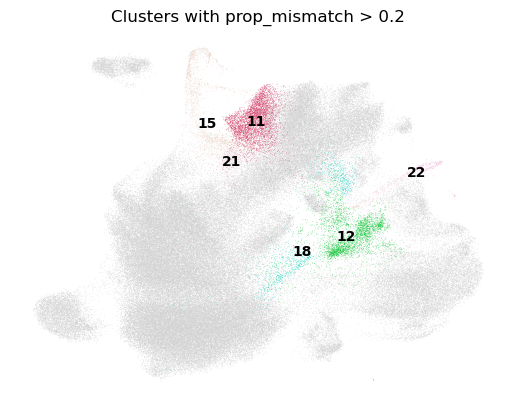

In [37]:
mismatch_clusters = (
    cluster_summary               # the table you printed in cell [17]
      .query("prop_mismatch > 0.2")
      .index                      # these are the cluster labels
      .astype(str)                # Scanpy stores cluster labels as strings
      .tolist()
)

print("Clusters to highlight:", mismatch_clusters)

# --- 2. draw the UMAP, colouring by cluster and highlighting just those ------
sc.pl.umap(
    adata_all,
    color="cluster",              # column that stores the cluster ID
    groups=mismatch_clusters,     # only show these clusters in colour
    legend_loc="on data",         # put the labels on the plot
    frameon=False,
    na_in_legend=False, 
    title="Clusters with prop_mismatch > 0.2"
)

/app/software/scanpy/1.9.3-foss-2022b/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


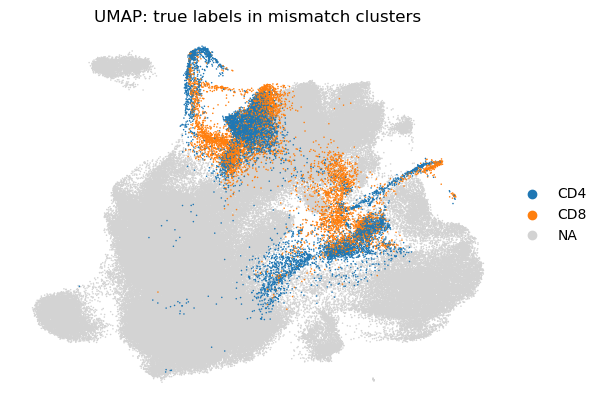

In [38]:
t_cells = {'CD4':[
'CD4 CTL',
'CD4 Naive',
'CD4 Proliferating',
'CD4 TCM',
'CD4 TEM', 'Treg'], 'CD8':[
'CD8 Naive',
'CD8 Proliferating',
'CD8 TCM',
'CD8 TEM']
}
sub2label = {}
for label, subs in t_cells.items():
    for sub in subs:
        sub2label[sub] = label

#  map existing SubCellType column to the new labels
adata_all.obs['cell_type_true_label'] = (
    adata_all.obs['predicted.celltype.l2']
    .map(sub2label)
    .fillna('Unknown')      # in case there are SubCellTypes not in t_cells
)

# boolean mask of cells in those clusters
mask = adata_all.obs['cluster'].astype(str).isin(mismatch_clusters)

# create a one‐column “highlight”:
#   CD4 or CD8 for mismatches, Other otherwise
adata_all.obs['highlight'] = np.where(
    mask,
    adata_all.obs['cell_type_true_label'],
    'Other'
)

# now plot exactly like your first plot:
sc.pl.umap(
    adata_all,
    color='highlight',          # this column is now categorical: CD4, CD8, Other
    groups=['CD4','CD8'],       # only these get the Scanpy default colors
    size=5,                    # same dot size as before
    frameon=False,
    legend_loc='right margin',  # or 'on data' if you prefer labels placed over clusters
    title='UMAP: true labels in mismatch clusters'
)

In [39]:
#adata_all.obs.to_csv('cell_types.csv',index = True)